# Exploratory Data Analysis - Variable Binning


### Why do we need to bin a continuous variable?

<b>Justification 1:</b> Suppose you want to predict the "purchase amount" at Walmart based on a range of customers' demographic information such as age, income, location, and etc. Assume "age" is a continous variable. If you just regress "purchase amount" on "age", you will either get statistically insignificant result or a weak positive/negative coefficient. What does the sign mean? It means older customers will buy more. It probably makes no sense that Age 80+ will buy more than 40-50 years old.   

<b>Justification 2:</b> Many unpervised ML techniques (e.g. clustering) or supervised ML techniques (e.g. logistic regression) still require variable preparation including binning, capping and flooring.

### Three methods covered in this notebook:
* Method 1: Equal size binning</b>
* Method 2: Use rPart</b>
* Method 3: Weight of Evidence (WOE) binning

### What else in this notebook?
* model.matrix: have you used model.matrix to create the design matrix? In a regression Y = XB + e, the matrix X is called the "design matrix".
* quantile(): to find the values at given percentiles. 

### Load the dataset

I will use the dataset "audit" in library(rattle.data) to illustrate the process. Click [here](https://cran.r-project.org/web/packages/rattle.data/rattle.data.pdf) for the variable definitions. I will only use one continous variable "income" and the target variable "TARGET_Adjusted".

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.2     ✔ dplyr   0.7.4
✔ tidyr   0.8.0     ✔ stringr 1.3.0
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


ID,Age,Employment,Education,Marital,Occupation,Income,Gender,Deductions,Hours,IGNORE_Accounts,RISK_Adjustment,TARGET_Adjusted
1004641,38,Private,College,Unmarried,Service,81838.00,Female,0,72,UnitedStates,0,0
1010229,35,Private,Associate,Absent,Transport,72099.00,Male,0,30,Jamaica,0,0
1024587,32,Private,HSgrad,Divorced,Clerical,154676.74,Male,0,40,UnitedStates,0,0
1038288,45,Private,Bachelor,Married,Repair,27743.82,Male,0,55,UnitedStates,7298,1
1044221,60,Private,College,Married,Executive,7568.23,Male,0,40,UnitedStates,15024,1
1047095,74,Private,HSgrad,Married,Service,33144.40,Male,0,30,UnitedStates,0,0



   0    1 
1537  463 

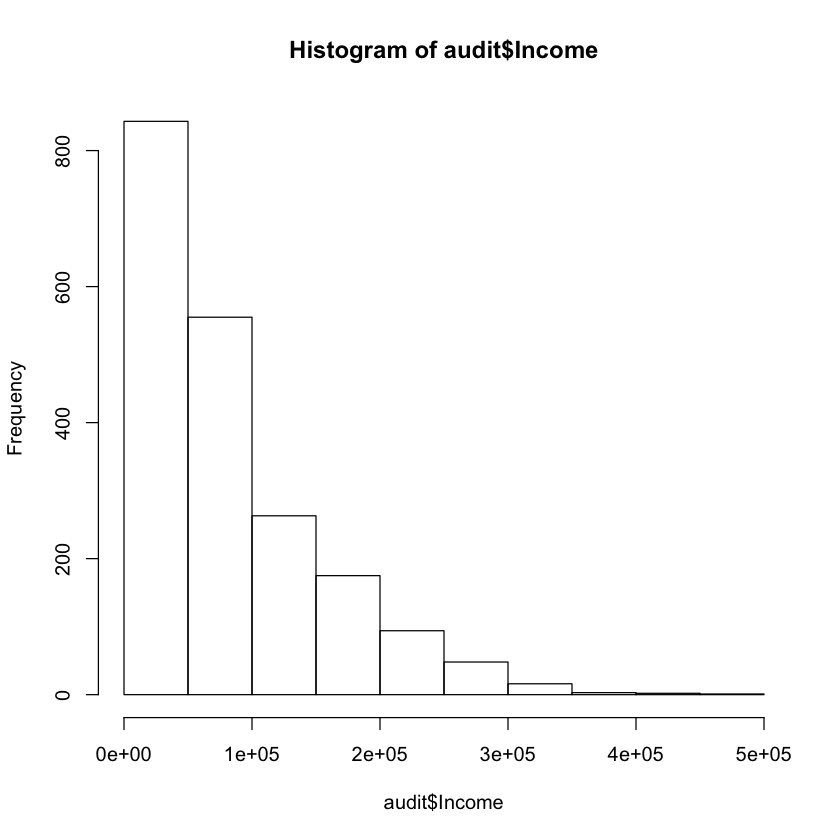

In [1]:
library("rattle.data")
library("tidyverse")
head(audit)
table(audit$TARGET_Adjusted)
hist(audit$Income)

## Partition the data into train, validation and test

Remember you should only use information from the training dataset, but not from the untouched datasets. The binned values will be applied to the whole dataset.

In [2]:
# set the seed to make your partition reproducible
set.seed(123)
spec = c(train = .5, test = .25, validate = .25)


g = sample(cut(
  seq(nrow(audit)), 
  nrow(audit)*cumsum(c(0,spec)),
  labels = names(spec)
))

# Create in a list "auditData". It has three elements: 
#  auditData$train is the training dataset
#  auditData$test is the test dataset
#  auditData$validate is the validation dataset

auditData = split(audit, g)

# Check the results:
sapply(auditData, nrow)/nrow(audit)

train     test validate 
    0.50     0.25     0.25

In [3]:
train    = auditData$train
test     = auditData$test
validate = auditData$validate

## Method 1 - Equal size binning

#### Step 1: Fine the cut points using the training dataset

In [4]:
train.income.cut = quantile(train$Income, prob = seq(0, 1, 0.1))
train.income.cut
train.age.cut    = quantile(train$Age, prob = seq(0, 1, 0.1))
train.age.cut

0%       10%       20%       30%       40%       50%       60%       70% 
   609.72  22590.56  30960.27  37987.95  47117.79  58687.10  76652.12  99319.81 
      80%       90%      100% 
133009.05 190674.21 481259.50

0%  10%  20%  30%  40%  50%  60%  70%  80%  90% 100% 
17.0 22.0 26.0 29.0 33.0 37.0 41.4 45.3 51.0 59.0 90.0

#### Step 2: Apply to the whole dataset
Apply the above break values to create new variables called "Income.equalSize" and "Age.equalSize" (using mutate in dplyr).

In [5]:
equalSize <- audit %>% 
    mutate(Income.equalSize = cut(Income, breaks = train.income.cut),
           Age.equalSize = cut(Age, breaks = train.age.cut)
          ) %>%
    select(ID, Age, Income,Income.equalSize, Age.equalSize)
head(equalSize)

ID,Age,Income,Income.equalSize,Age.equalSize
1004641,38,81838.00,"(7.67e+04,9.93e+04]","(37,41.4]"
1010229,35,72099.00,"(5.87e+04,7.67e+04]","(33,37]"
1024587,32,154676.74,"(1.33e+05,1.91e+05]","(29,33]"
1038288,45,27743.82,"(2.26e+04,3.1e+04]","(41.4,45.3]"
1044221,60,7568.23,"(610,2.26e+04]","(59,90]"
1047095,74,33144.40,"(3.1e+04,3.8e+04]","(59,90]"


#### Step 3: Create the design matrix
model.matrix creates a design (or model) matrix, e.g., by expanding factors to a set of dummy variables (depending on the contrasts) and expanding interactions similarly. Click [here](https://www.rdocumentation.org/packages/stats/versions/3.5.1/topics/model.matrix) for reference.

In [6]:
equalSize.matrix = model.matrix(~Income.equalSize+Age.equalSize,equalSize)
head(equalSize.matrix)

,(Intercept),"Income.equalSize(2.26e+04,3.1e+04]","Income.equalSize(3.1e+04,3.8e+04]","Income.equalSize(3.8e+04,4.71e+04]","Income.equalSize(4.71e+04,5.87e+04]","Income.equalSize(5.87e+04,7.67e+04]","Income.equalSize(7.67e+04,9.93e+04]","Income.equalSize(9.93e+04,1.33e+05]","Income.equalSize(1.33e+05,1.91e+05]","Income.equalSize(1.91e+05,4.81e+05]","Age.equalSize(22,26]","Age.equalSize(26,29]","Age.equalSize(29,33]","Age.equalSize(33,37]","Age.equalSize(37,41.4]","Age.equalSize(41.4,45.3]","Age.equalSize(45.3,51]","Age.equalSize(51,59]","Age.equalSize(59,90]"
1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
2,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
3,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## Method 2 - Use rpart to find the cut points

#### Step 1: Fine the cut points using the training dataset

In [10]:
library(rpart)

# Income
income.fit <- rpart(TARGET_Adjusted ~ Income, data=train)
print(income.fit)
#rpart.plot(income.fit)

# Age
age.fit <- rpart(TARGET_Adjusted ~ Age, data=train)
print(age.fit)
#rpart.plot(age.fit)

n= 1000 

node), split, n, deviance, yval
      * denotes terminal node

1) root 1000 176.55900 0.22900000  
  2) Income>=53672.67 530  52.43208 0.11132080  
    4) Income>=76932.35 398  28.58543 0.07788945 *
    5) Income< 76932.35 132  22.06061 0.21212120 *
  3) Income< 53672.67 470 108.51060 0.36170210 *
n= 1000 

node), split, n, deviance, yval
      * denotes terminal node

1) root 1000 176.55900 0.22900000  
  2) Age< 27.5 258  10.53101 0.04263566 *
  3) Age>=27.5 742 153.95150 0.29380050  
    6) Age< 36.5 220  35.20000 0.20000000 *
    7) Age>=36.5 522 116.00000 0.33333330 *


#### Step 2: Apply to the whole dataset

From Step 1 we know the break points for income are 53672.67 and 76932.35. Remember to add the lower bound (-Inf) and upper bound (Inf) in the code. You can specify other meaningful values.

In [16]:
equalSize <- audit %>% 
    mutate(Income.equalSize = cut(Income, breaks = c(-Inf, 53672.67,76932.35, Inf)),
           Age.equalSize = cut(Age, breaks = c(-Inf, 27.5, 36.5, Inf))
          ) %>%
    select(ID, Age, Income,Income.equalSize, Age.equalSize)
head(equalSize)

ID,Age,Income,Income.equalSize,Age.equalSize
1004641,38,81838.00,"(7.69e+04, Inf]","(36.5, Inf]"
1010229,35,72099.00,"(5.37e+04,7.69e+04]","(27.5,36.5]"
1024587,32,154676.74,"(7.69e+04, Inf]","(27.5,36.5]"
1038288,45,27743.82,"(-Inf,5.37e+04]","(36.5, Inf]"
1044221,60,7568.23,"(-Inf,5.37e+04]","(36.5, Inf]"
1047095,74,33144.40,"(-Inf,5.37e+04]","(36.5, Inf]"


In [25]:
# Check the results
table(equalSize$Age.equalSize)
table(equalSize$Income.equalSize)


(-Inf,20]   (20,22]   (22,31] (31, Inf] 
      132       108       474      1286 


(-Inf,6.74e+04] (6.74e+04, Inf] 
           1100             900 

#### Step 3: Create the design matrix

In [17]:
equalSize.matrix = model.matrix(~Income.equalSize+Age.equalSize,equalSize)
head(equalSize.matrix)

,(Intercept),"Income.equalSize(5.37e+04,7.69e+04]","Income.equalSize(7.69e+04, Inf]","Age.equalSize(27.5,36.5]","Age.equalSize(36.5, Inf]"
1,1,0,1,0,1
2,1,1,0,1,0
3,1,0,1,1,0
4,1,0,0,0,1
5,1,0,0,0,1
6,1,0,0,0,1


## Method 3: WOE binning
The weight of evidence tells the predictive power of an independent variable in relation to the dependent variable. We will use the library "woeBinning". Click [here](https://cran.r-project.org/web/packages/woeBinning/woeBinning.pdf) for the R CRAN document.
To understand more about WOE, click [here](https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html).

In [19]:
#install.packages("woeBinning")
library(woeBinning)

#### Step 1: Fine the cut points using the training dataset

In [20]:
# Income 
income.woe <- woe.binning(audit,'TARGET_Adjusted', 'Income')
income.woe

# Age
age.woe <- woe.binning(audit,'TARGET_Adjusted', 'Age')
age.woe

,woe,cutpoints.final,cutpoints.final[-1],iv.total.final,1,0,col.perc.a,col.perc.b,iv.bins
"(-Inf,67416.759]",52.03192,-Inf,67416.759,0.480177,370,730,0.7991361,0.4749512,0.1686796
"(67416.759, Inf]",-96.08635,67416.76,Inf,0.480177,93,807,0.2008639,0.5250488,0.3114974
Missing,NA,Inf,Missing,0.480177,0,0,0.0000000,0.0000000,NA


,woe,cutpoints.final,cutpoints.final[-1],iv.total.final,1,0,col.perc.a,col.perc.b,iv.bins
"(-Inf,20]",-675.67183,-Inf,20,0.999798,0,132,9.996002e-05,0.08594721,0.5800457
"(20,22]",-274.89941,20,22,0.999798,2,106,4.417887e-03,0.06903790,0.1776400
"(22,31]",-78.97308,22,31,0.999798,57,417,1.231609e-01,0.27129922,0.1169894
"(31, Inf]",41.90239,31,Inf,0.999798,404,882,8.723213e-01,0.57371567,0.1251229
Missing,NA,Inf,Missing,0.999798,0,0,0.000000e+00,0.00000000,NA


#### Step 2: Apply to the whole dataset

In [21]:
equalSize <- audit %>% 
    mutate(Income.equalSize = cut(Income, breaks = c(-Inf, 67416.759, Inf)),
           Age.equalSize = cut(Age, breaks = c(-Inf, 20, 22,31, Inf))
          ) %>%
    select(ID, Age, Income,Income.equalSize, Age.equalSize)
head(equalSize)

ID,Age,Income,Income.equalSize,Age.equalSize
1004641,38,81838.00,"(6.74e+04, Inf]","(31, Inf]"
1010229,35,72099.00,"(6.74e+04, Inf]","(31, Inf]"
1024587,32,154676.74,"(6.74e+04, Inf]","(31, Inf]"
1038288,45,27743.82,"(-Inf,6.74e+04]","(31, Inf]"
1044221,60,7568.23,"(-Inf,6.74e+04]","(31, Inf]"
1047095,74,33144.40,"(-Inf,6.74e+04]","(31, Inf]"


In [24]:
# Check the results
table(equalSize$Age.equalSize)
table(equalSize$Income.equalSize)


(-Inf,20]   (20,22]   (22,31] (31, Inf] 
      132       108       474      1286 


(-Inf,6.74e+04] (6.74e+04, Inf] 
           1100             900 

#### Step 3: Create the design matrix

In [22]:
equalSize.matrix = model.matrix(~Income.equalSize+Age.equalSize,equalSize)
head(equalSize.matrix)

,(Intercept),"Income.equalSize(6.74e+04, Inf]","Age.equalSize(20,22]","Age.equalSize(22,31]","Age.equalSize(31, Inf]"
1,1,1,0,0,1
2,1,1,0,0,1
3,1,1,0,0,1
4,1,0,0,0,1
5,1,0,0,0,1
6,1,0,0,0,1
